## Imports

In [3]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler


import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import sys
import os

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D, plot_grid
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DTYPE = torch.float32

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Misc Utilities

In [4]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-1

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l

class DiagNLLLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(DiagNLLLoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        y_predictions, y_sigmas = y_pred 

        # Returns log(sigma^2)
        #l1 = y_predictions.shape[0] * y_sigmas.sum() + torch.sum(torch.pow((y_true - y_predictions), 2) / torch.exp(y_sigmas))

        # Return sigma^2
        y_sigmas = y_sigmas**2
        l2 = torch.log(torch.prod(y_sigmas, dim=1) + self.eta)*y_predictions.shape[0] + torch.sum(torch.pow((y_true - y_predictions), 2)/ y_sigmas)

        return l2


## Data Generation

Out noise


/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


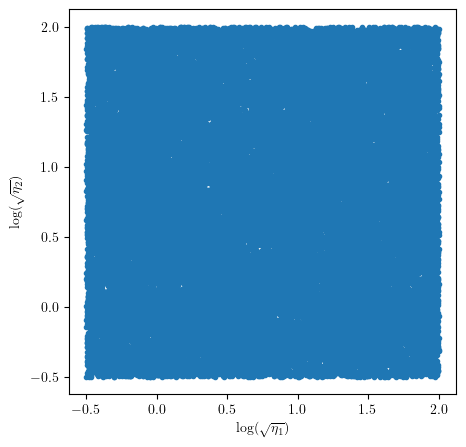

In [12]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = True
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([-0.5, 0.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All", noise_type='out_noise', d_condition="<=", noise = 0.0001)

etas_test, gs_test = generate_log_data(SSG_gen, log, 800, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [13]:
from sklearn.preprocessing import StandardScaler

# Custom Scaling
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=DTYPE)
y_train = torch.tensor(y_scaled_train, dtype=DTYPE)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=DTYPE)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=DTYPE)

## Network Training

In [14]:
# Defining model parameters
chkpt_dir = '../Model_Checkpoints/MCD/Aleatoric/'
chkpt_prefix = 'D_LT_0_Alea_40k_'

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
        "dropout": [0.001, 0.001, 0.001],
        "out_noise": True,
        'out_noise_scale' : 1.0,

}

train_params = {
        "criterion": DiagNLLLoss,
        "optimizer": torch.optim.Adam,
        #"optimizer__weight_decay": 1e-7,
        "lr": 0.001,
        "batch_size": 256,
        "max_epochs": 1000,
        "device": device,
        "iterator_train__shuffle": True,
        #"iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        #"iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 2,
        'warm_start' : True,
}

test_criteria = RMSELoss()

In [76]:
net_name = chkpt_prefix + 'MCD1'

callbacks = [EarlyStopping(patience=15, threshold=0.000001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
        #Checkpoint(monitor='valid_loss_best', f_params=net_name+'.pt', dirname=chkpt_dir),
        LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.000001, threshold_mode='abs', mode='min', verbose=True)
]
train_params['callbacks'] = callbacks


net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)

net = net.fit(x_train, y_train)

net.load_params(f_params=chkpt_dir+net_name+'.pt')
test_pred = net.predict(x_test)

print(f"\t\tTest loss: {test_criteria(torch.tensor(test_pred),y_test)}")

/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      733.1793      622.2877  0.0789
      2      590.9080      451.1684  0.0776
      3      375.3725      229.4480  0.0755
      4      157.6543       48.8145  0.0761
      5      -14.1673     -101.3058  0.0723
      6     -159.5764     -229.2262  0.0697
      7     -285.3988     -346.0553  0.0761
      8     -400.6113     -456.9474  0.0748
      9     -515.1281     -570.1421  0.0728
     10     -630.8624     -689.0248  0.0816
     11     -752.2958     -814.7174  0.0750
     12     -883.3288     -951.5627  0.0736
     13    -1027.3162    -1101.7867  0.1542
     14    -1185.3906    -1272.2664  0.0753
     15    -1370.9198    -1471.5508  0.0759
     16    -1581.6719    -1703.3792  0.0717
     17    -1844.4692    -2004.7038  0.0803
     18    -2172.9690    -2411.0925  0.0833
     19    -2644.9721    -3022.8098  0.0783
     20    -2967.0584    -3480.4176  0.0866
     21    -3324.8917    -3669.7

In [77]:
sigmas = net.module.sigma.detach().cpu().numpy()

sigmas = sigmas * y_scaler.scale_  # Scale back to original scale
#sigmas = np.sqrt(np.exp(sigmas))* y_scaler.scale_  # Scale back to original scale

print(sigmas)

test_pred = y_scaler.inverse_transform(net.predict(x_test))

test_loss = test_criteria(torch.tensor(test_pred), torch.tensor(gs_test))

print(f"Test loss: {test_loss}")

[[0.00237507 0.00177987 0.00165513]]
Test loss: 0.05012163350153969


## Reinitializing Trained Model

In [15]:
chkpt_dir = '../Model_Checkpoints/MCD/Aleatoric/'
chkpt_prefix = 'Regular_Alea_40k'
net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
net = reinitialize_model(chkpt_dir + chkpt_prefix + '_MCD1.pt', net)


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


## Generating Statistics Data

Mean error: 0.0015028462974857524
MAPE 0.003852673558428941


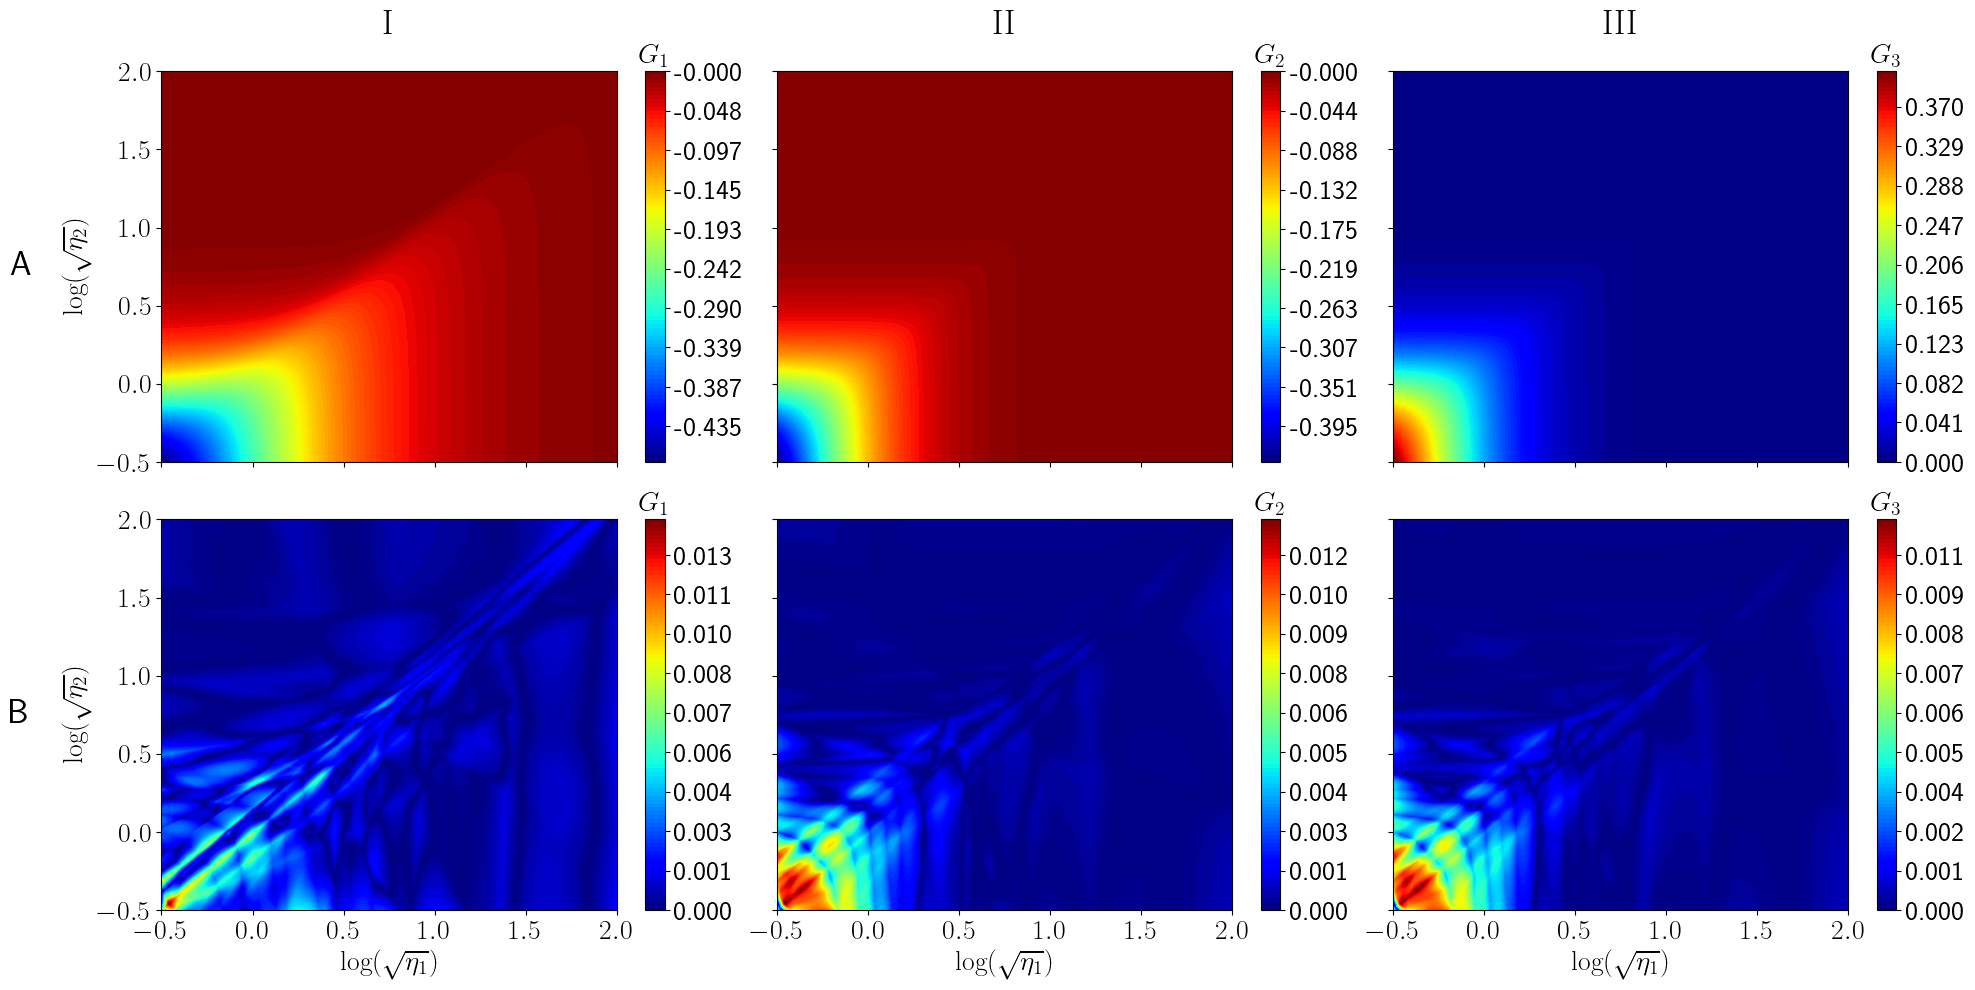

In [16]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

pred = net.predict(etas.astype(np.float32))

pred = y_scaler.inverse_transform(pred)

pred = pred.T.reshape(3, dim, dim)

error = test_criteria(torch.tensor(pred), torch.tensor(target))

print(f"Mean error: {error}")

print(f"MAPE {MAPELoss()(torch.tensor(pred), torch.tensor(target))}")

row_titles = ["A", "B", "C"]
col_titles = [r"$\mathrm{I}$", r"$\mathrm{II}$", r"$\mathrm{III}$"]

formatter = lambda x, pos: f"{x:>6.3f}"

plot_grid(x_grid, y_grid, [target, np.abs(pred-target)], row_titles, col_titles, formatter, figsize=(20,10), ind_scales=True)

## Generating Model Uncertainty From Dropout

In [17]:
T = 200
predictions = np.zeros((T, dim*dim, 3))

batch_size = dim*dim // 2

net.module.dropout_on()

for i in range(T):
    batches = np.zeros((len(etas)//batch_size, batch_size , 3))
    for j in range(len(etas)//batch_size):
        batches[j] = net.module(torch.tensor(etas[j*batch_size:(j+1)*batch_size], dtype=torch.float32).to(device), noise=False).cpu().detach()
    predictions[i] = y_scaler.inverse_transform(batches.reshape(dim*dim, 3))
    del batches

In [18]:
mean_pred = np.mean(predictions, axis=0)

std_pred = np.std(predictions, axis=0)

if "out_noise" in net_params and net_params["out_noise"]:
    sigmas = net.module.sigma.cpu().detach().numpy()* y_scaler.scale_  # Scale back to original scale
    print(f"Sigmas: {sigmas}")
    std_pred = np.sqrt(std_pred**2 + sigmas**2)
    np.savetxt('../data/MCD/' + chkpt_prefix + '_Sigmas.csv', sigmas, delimiter=',')


np.savetxt('../data/MCD/' + chkpt_prefix + '_Pred_Mean.csv', mean_pred, delimiter=',')
np.savetxt('../data/MCD/' + chkpt_prefix + '_Pred_Std.csv', std_pred, delimiter=',')

Sigmas: [[0.00224679 0.0016363  0.00153865]]


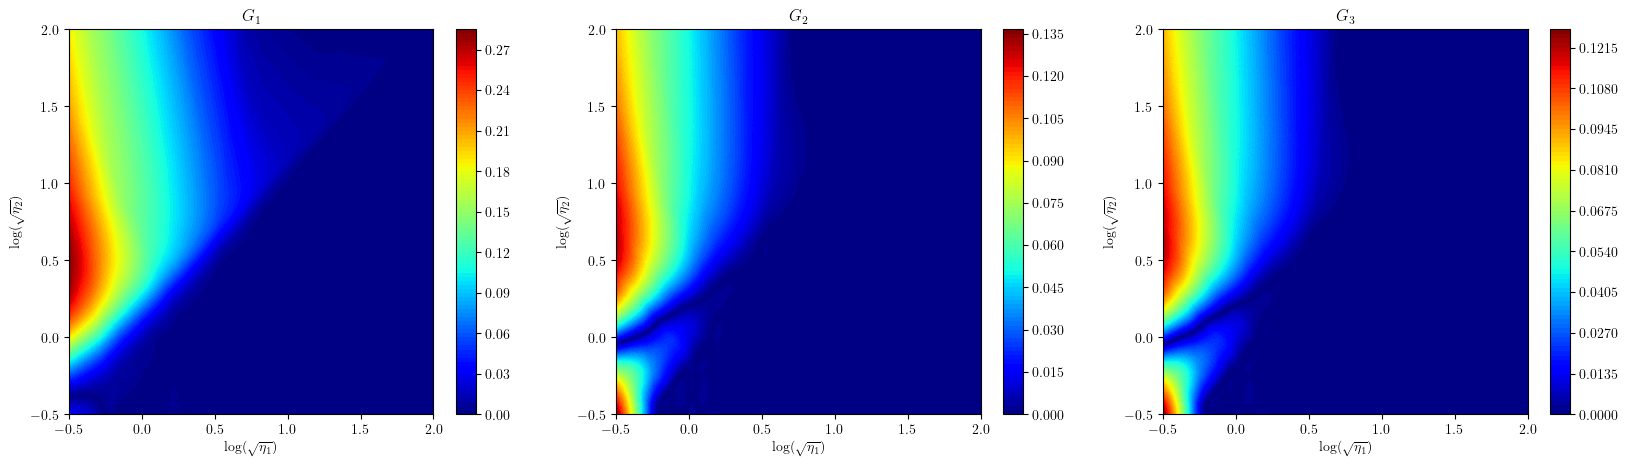

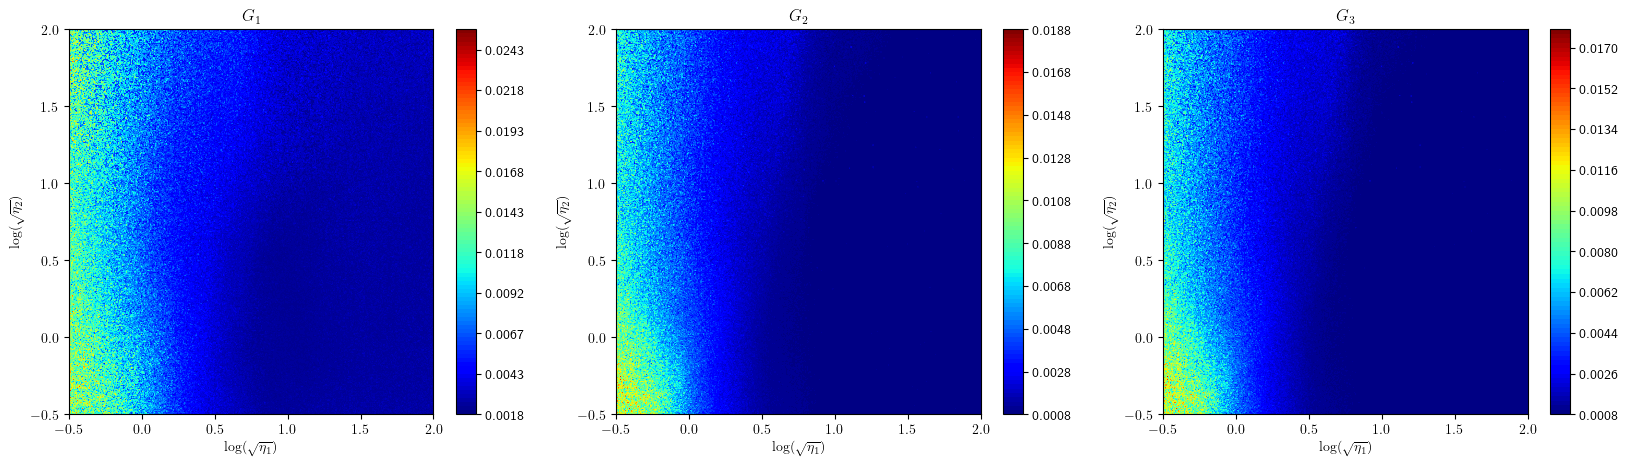

In [153]:
plot_heat_map_loss(x_grid, y_grid, target, mean_pred.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, std_pred.T.reshape(3, dim, dim), title="MC Dropout Standard Deviation", sup_title=False)

## Visualizing Different Samples

### Getting Predictions from different networks

In [10]:
names = ['TurbulenceNetwork_MCD1.pt', 'TurbulenceNetwork_MCD2.pt', 'TurbulenceNetwork_MCD3.pt']

T = 100

preds = []
labels = []

for i, name in enumerate(names):
    net = reinitialize_model(name, checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    net.module.dropout_on()
    predictions = np.zeros((T, x_vis.shape[0], 3))
    for j in range(T):
        predictions[j] = y_scaler.inverse_transform(net.module(x_vis.to(device)).cpu().detach().numpy())
    preds.append(predictions.reshape(T, -1))
    labels.append(i*np.ones(T))

y_trans = y_scaler.inverse_transform(y_vis.cpu().detach().numpy()).reshape(1, -1)

preds.append(y_trans)
labels.append([labels[-1][-1] + 1])

test_outputs = np.concatenate(preds, axis=0)
test_labels = np.concatenate(labels, axis=0)

error = np.abs(test_outputs - y_trans)
print(f"Mean error: {np.mean(error)}")

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Mean error: 0.0007547131479917355


### Visualizing

Calculating PHATE...
  Running PHATE on 301 observations and 2400 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.99 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 3.13 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 0.27 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.07 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.13 seconds.
Calculated PHATE in 3.62 seconds.


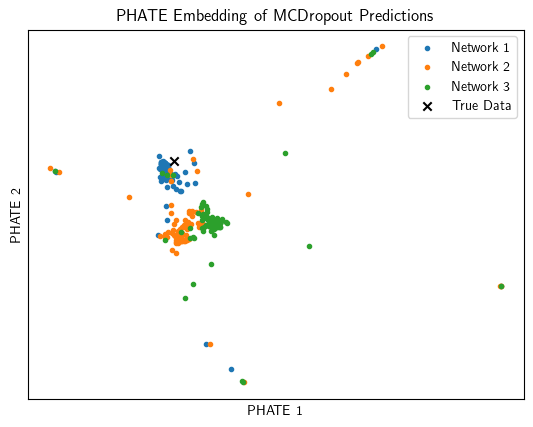

In [11]:
from phate import PHATE

phate_op = PHATE(n_components=2)

phate_output = phate_op.fit_transform(test_outputs)

for i, name in enumerate(names):
    plt.scatter(phate_output[test_labels == i, 0], phate_output[test_labels == i, 1], label=f"Network {i+1}", marker='.')

plt.scatter(phate_output[-1, 0], phate_output[-1, 1], label="True Data", marker='x', color='black')

plt.title("PHATE Embedding of MCDropout Predictions")

plt.xlabel("PHATE 1")
plt.xticks([])

plt.ylabel("PHATE 2")
plt.yticks([])

plt.legend()
plt.show()

In [15]:
net_dict = torch.load(checkpoint_dir+net_name+'.pt')

new_dict = {}
i = 1
for key, value in net_dict.items():
    print(key)
    layer_num = i
    if "weight" in key:
        name = f"w{layer_num}"
    else:
        name = f"b{layer_num}"
        i += 1
    
    new_dict[name] = value.cpu().detach().numpy()


for key, value in new_dict.items():
    print(key, value.shape)

pickle.dump(new_dict, open('NUTS_Initialize_large.pkl', 'wb')) 



layers.0.weight
layers.0.bias
layers.3.weight
layers.3.bias
layers.6.weight
layers.6.bias
layers.9.weight
layers.9.bias
w1 (20, 2)
b1 (20,)
w2 (20, 20)
b2 (20,)
w3 (20, 20)
b3 (20,)
w4 (3, 20)
b4 (3,)
